In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull
import boost_histogram as bh


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def theta_x(x, y, z):
    return x/z

def theta_y(x, y, z):
    return y/z

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))

def theta_x_y(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    tanx = theta_x(x_vec, y_vec, z_vec)
    tany = theta_y(x_vec, y_vec, z_vec)
    
    return tanx, tany

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi

def poisson_to_Z(N, lam):
    N = np.asarray(N, dtype=float)
    lam = np.asarray(lam, dtype=float)
    
    # Poisson CDF
    p = np.where(N >= lam,
                 poisson.cdf(N, lam),
                 1.0 - poisson.cdf(N, lam))
    
    # clip to avoid 0 or 1
    eps = 1e-16
    p = np.clip(p, eps, 1 - eps)
    
    # sign convention
    s = np.sign(lam - N)
    
    return s * norm.ppf(p)

def compute_kde_density(data, bandwidth, positions, phi_shape):
    values = np.vstack([np.array(data)[:,1], np.array(data)[:,0]])
    kernel = st.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=bandwidth)
    density = np.reshape(kernel(positions).T, phi_shape)
    
    total_events = len(data)
    bin_area = (phi_grid[1]-phi_grid[0]) * (theta_grid[1]-theta_grid[0])
    return density * total_events * bin_area  # Convert to estimated counts

In [2]:
path = '/home/jiajun/github/muography/data/planar_detector_v5/'
df = pd.read_pickle(path+'target_merge.pkl')
dg = pd.read_pickle(path+'free_merge.pkl')

In [ ]:
import boost_histogram as bh
Zs = []
def project_point(r,x,y,z,x1,y1,z1):
    vx = x-x1
    vy = y-y1
    vz = z-z1
    theta = np.degrees(np.arccos(vz/np.sqrt(vx**2+vy**2+vz**2)))
    phi = phi_reconstruct(vx,vy,vz)plt.hist(gnn_large,label='GNN Large pixel',histtype='step',bins=25)
plt.hist(truth_large,label='Truth Large pixel',histtype='step',bins=25)
plt.xlabel(r'$\theta$ (degrees)')
plt.legend()
    d = np.sqrt(vx**2+vy**2+vz**2)
    radius = np.arcsin(r/d)
    return radius, theta, phi
    
colors = [
    (1, 0, 0),    # Red
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 1, 0),    # Yellow
    (0, 1, 1),    # Cyan
    (1, 0, 1),    # Magenta
    (0.5, 0, 0),  # Maroon
    (0, 0.5, 0),  # Dark Green
    (0, 0, 0.5),  # Navy
    (1, 0.5, 0)   # Orange
]
import matplotlib.colors as mcolors

# 2. Create the discrete colormap
cmap = mcolors.ListedColormap(colors)

target_pos = [
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]
radius = [20, 5, 5, 5, 10, 10]
num = 10

acceptance = 1.5

positions_x=[0, 0, 0, 0, 50, 50, 50, -25, -25, -25]
positions_y=[0, 0, 0, 0, 0, 0, 0, -25, -25, -25]
positions_z=[1, -25, -50, -100, -25, -50, -100, -25, -50, -100]

fig, ax = plt.subplots(3,num,figsize=(9*num,20),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05,hspace=0.15)
plt.suptitle('Detector: Square 128 Channels',fontsize=60,y=1)
H_list = []
im_handles = [None, None, None]
theta_bin = np.linspace(5, 65, 35) #np.logspace(0.69897,1.7708520116421442, 15)
phi_bin = np.linspace(0, 360, 15)
num_bins = 10
discrete_cmap = plt.cm.get_cmap('viridis', num_bins)

ratio_hists = []
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = np.column_stack((df['GNN_theta'][df['detector']==i].to_numpy(),df['GNN_phi'][df['detector']==i].to_numpy()))
    reco_sim_angle = np.column_stack((dg['GNN_theta'][dg['detector']==i].to_numpy(),dg['GNN_phi'][dg['detector']==i].to_numpy()))
    T, xedges, yedges = np.histogram2d(np.mod(reco_sim_angle[:,1], 360),reco_sim_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))

    H, xedges, yedges = np.histogram2d(np.mod(reco_data_angle[:,1], 360),reco_data_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(10,90)))
    H_list.append(H)
    plt.sca(ax[0,i%num])
    error = 1/np.sqrt(H.T)*100
    #T = np.where(error.T<20, T, 0)
    #H = np.where(error.T<20, H, 0)
    #plt.gca().add_patch(rect)
    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1
    #plt.colorbar(label='Counts')
    #plt.ylabel("Theta")
    plt.ylim(top=63)
    #plt.xlabel("Phi")
    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    #plt.legend()
    plt.colorbar(label='Statistical Error')
    
    # Plot the Z-map
    plt.sca(ax[1, i%num])

    #plt.gca().add_patch(rect)
    Z = poisson_to_Z(H, T)
    Z = np.clip(Z,-10,10)
    Zs.append(Z)
    im2 = plt.imshow(Z.T, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='copper', aspect='auto',vmin=-5,vmax=5)
    im_handles[1] = im2
    #plt.colorbar(label='Significance Z')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
    plt.title(f'Tar/Free Tracks: {len(reco_data_angle)}/{len(reco_sim_angle)}')
    #plt.legend()
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        #ax[1, i%num].add_patch(circle)
        #print(f'Phi:{ph:.2f},  Theta:{the:.2f}')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    # circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    # if -5<(ph+180)<365 and -5<the<70:
    #     plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    #ax[1, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    # circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    # if -5<(ph+180)<365 and -5<the<70:
    #     plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    # ax[1, i%num].add_patch(circle)
    
    plt.colorbar(label=r'Significance $\sigma$')
    
    plt.sca(ax[2,i%num])
    
    sim_H, sim_xedges, sim_yedges = np.histogram2d(
        np.mod(reco_sim_angle[:,1], 360), reco_sim_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    
    # Data histogram (note: should use reco_data_angle for both axes, not mix with reco_sim_angle[:,0]?)
    data_H, _, _ = np.histogram2d(
        np.mod(reco_data_angle[:,1], 360), reco_data_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    #sim_H = np.where(error.T<20, sim_H, 0)
    #data_H = np.where(error.T<20, data_H, 0)
    # Avoid divide-by-zero with masking
    #ratio = np.divide(data_H, sim_H, out=np.zeros_like(data_H, dtype=float), where=sim_H>0)
    ratio = np.divide(data_H, sim_H)

    #####
    ratio_hist = bh.Histogram(
        bh.axis.Variable(phi_bin),
        bh.axis.Variable(theta_bin),
    )    
    ratio_hist.view()[:] = ratio
    ratio_hists.append(ratio_hist)
    #####

    
    # Plot the ratio
    im3 = plt.imshow(
        ratio.T,                      # transpose so x=first axis, y=second
        origin="lower", 
        extent=[sim_xedges[0], sim_xedges[-1], sim_yedges[0], sim_yedges[-1]],
        aspect="auto",
        cmap='copper',
        vmin=0, vmax=2
    )
    im_handles[2] = im3
    #plt.colorbar(label=r'Transmission')
    plt.ylim(top=63)
    #plt.ylabel("Theta")
    #plt.xlabel("Phi")
   # your sphere center
    for j, pos in enumerate(target_pos):
        rad, the, ph = project_point(radius[j],*pos,positions_x[i],positions_y[i],positions_z[i])
        #plt.scatter(ph+180, the, c='r',s=10)
        circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='red', fill=False, linewidth=3, linestyle='--')
        if -5<(ph+180)<365 and -5<the<70:
            plt.text(np.mod(ph+180, 360), the, f'C{j}', size=20, c='r')
        ax[2, i%num].add_patch(circle)
    #plt.legend()
    rad, the, ph = project_point(10,12,7,-25,positions_x[i],positions_y[i],positions_z[i])
    # circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    # if -5<(ph+180)<365 and -5<the<70:
    #     plt.text(np.mod(ph+180, 360), the, f'B0', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    rad, the, ph = project_point(5,-30,-30,-10,positions_x[i],positions_y[i],positions_z[i])
    #circle = plt.Circle((np.mod(ph+180, 360), the), np.rad2deg(rad), color='blue', fill=False, linewidth=3, linestyle='--')
    #if -5<(ph+180)<365 and -5<the<70:
        ##plt.text(np.mod(ph+180, 360), the, f'B1', size=20, c='b')
    ax[2, i%num].add_patch(circle)
    
    plt.colorbar(label='Transmission')
    plt.xlabel('GNN Phi (degrees)', fontsize=35, labelpad=20)

ax[0, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel('GNN Theta (degrees)', fontsize=35, labelpad=20)

#ax[-1, -1].set_xlabel('Phi (degrees)', fontsize=35, labelpad=20)
H_min = min(h.min() for h in H_list)
H_max = max(h.max() for h in H_list)
#for row, im in enumerate(im_handles):
#    fig.colorbar(im, ax=ax[row,:], orientation='vertical', label=['Statistical Error','Significance Z','Transmission'][row], pad=0.01)
        
plt.show()

with open(path+"GNN_hists.pkl", "wb") as f:
    pickle.dump(ratio_hists, f)

/tmp/ipykernel_1895930/2724314467.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', num_bins)
/tmp/ipykernel_1895930/2724314467.py:70: RuntimeWarning: divide by zero encountered in divide
  error = 1/np.sqrt(H.T)*100
/tmp/ipykernel_1895930/2724314467.py:138: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(data_H, sim_H)
/tmp/ipykernel_1895930/2724314467.py:138: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(data_H, sim_H)


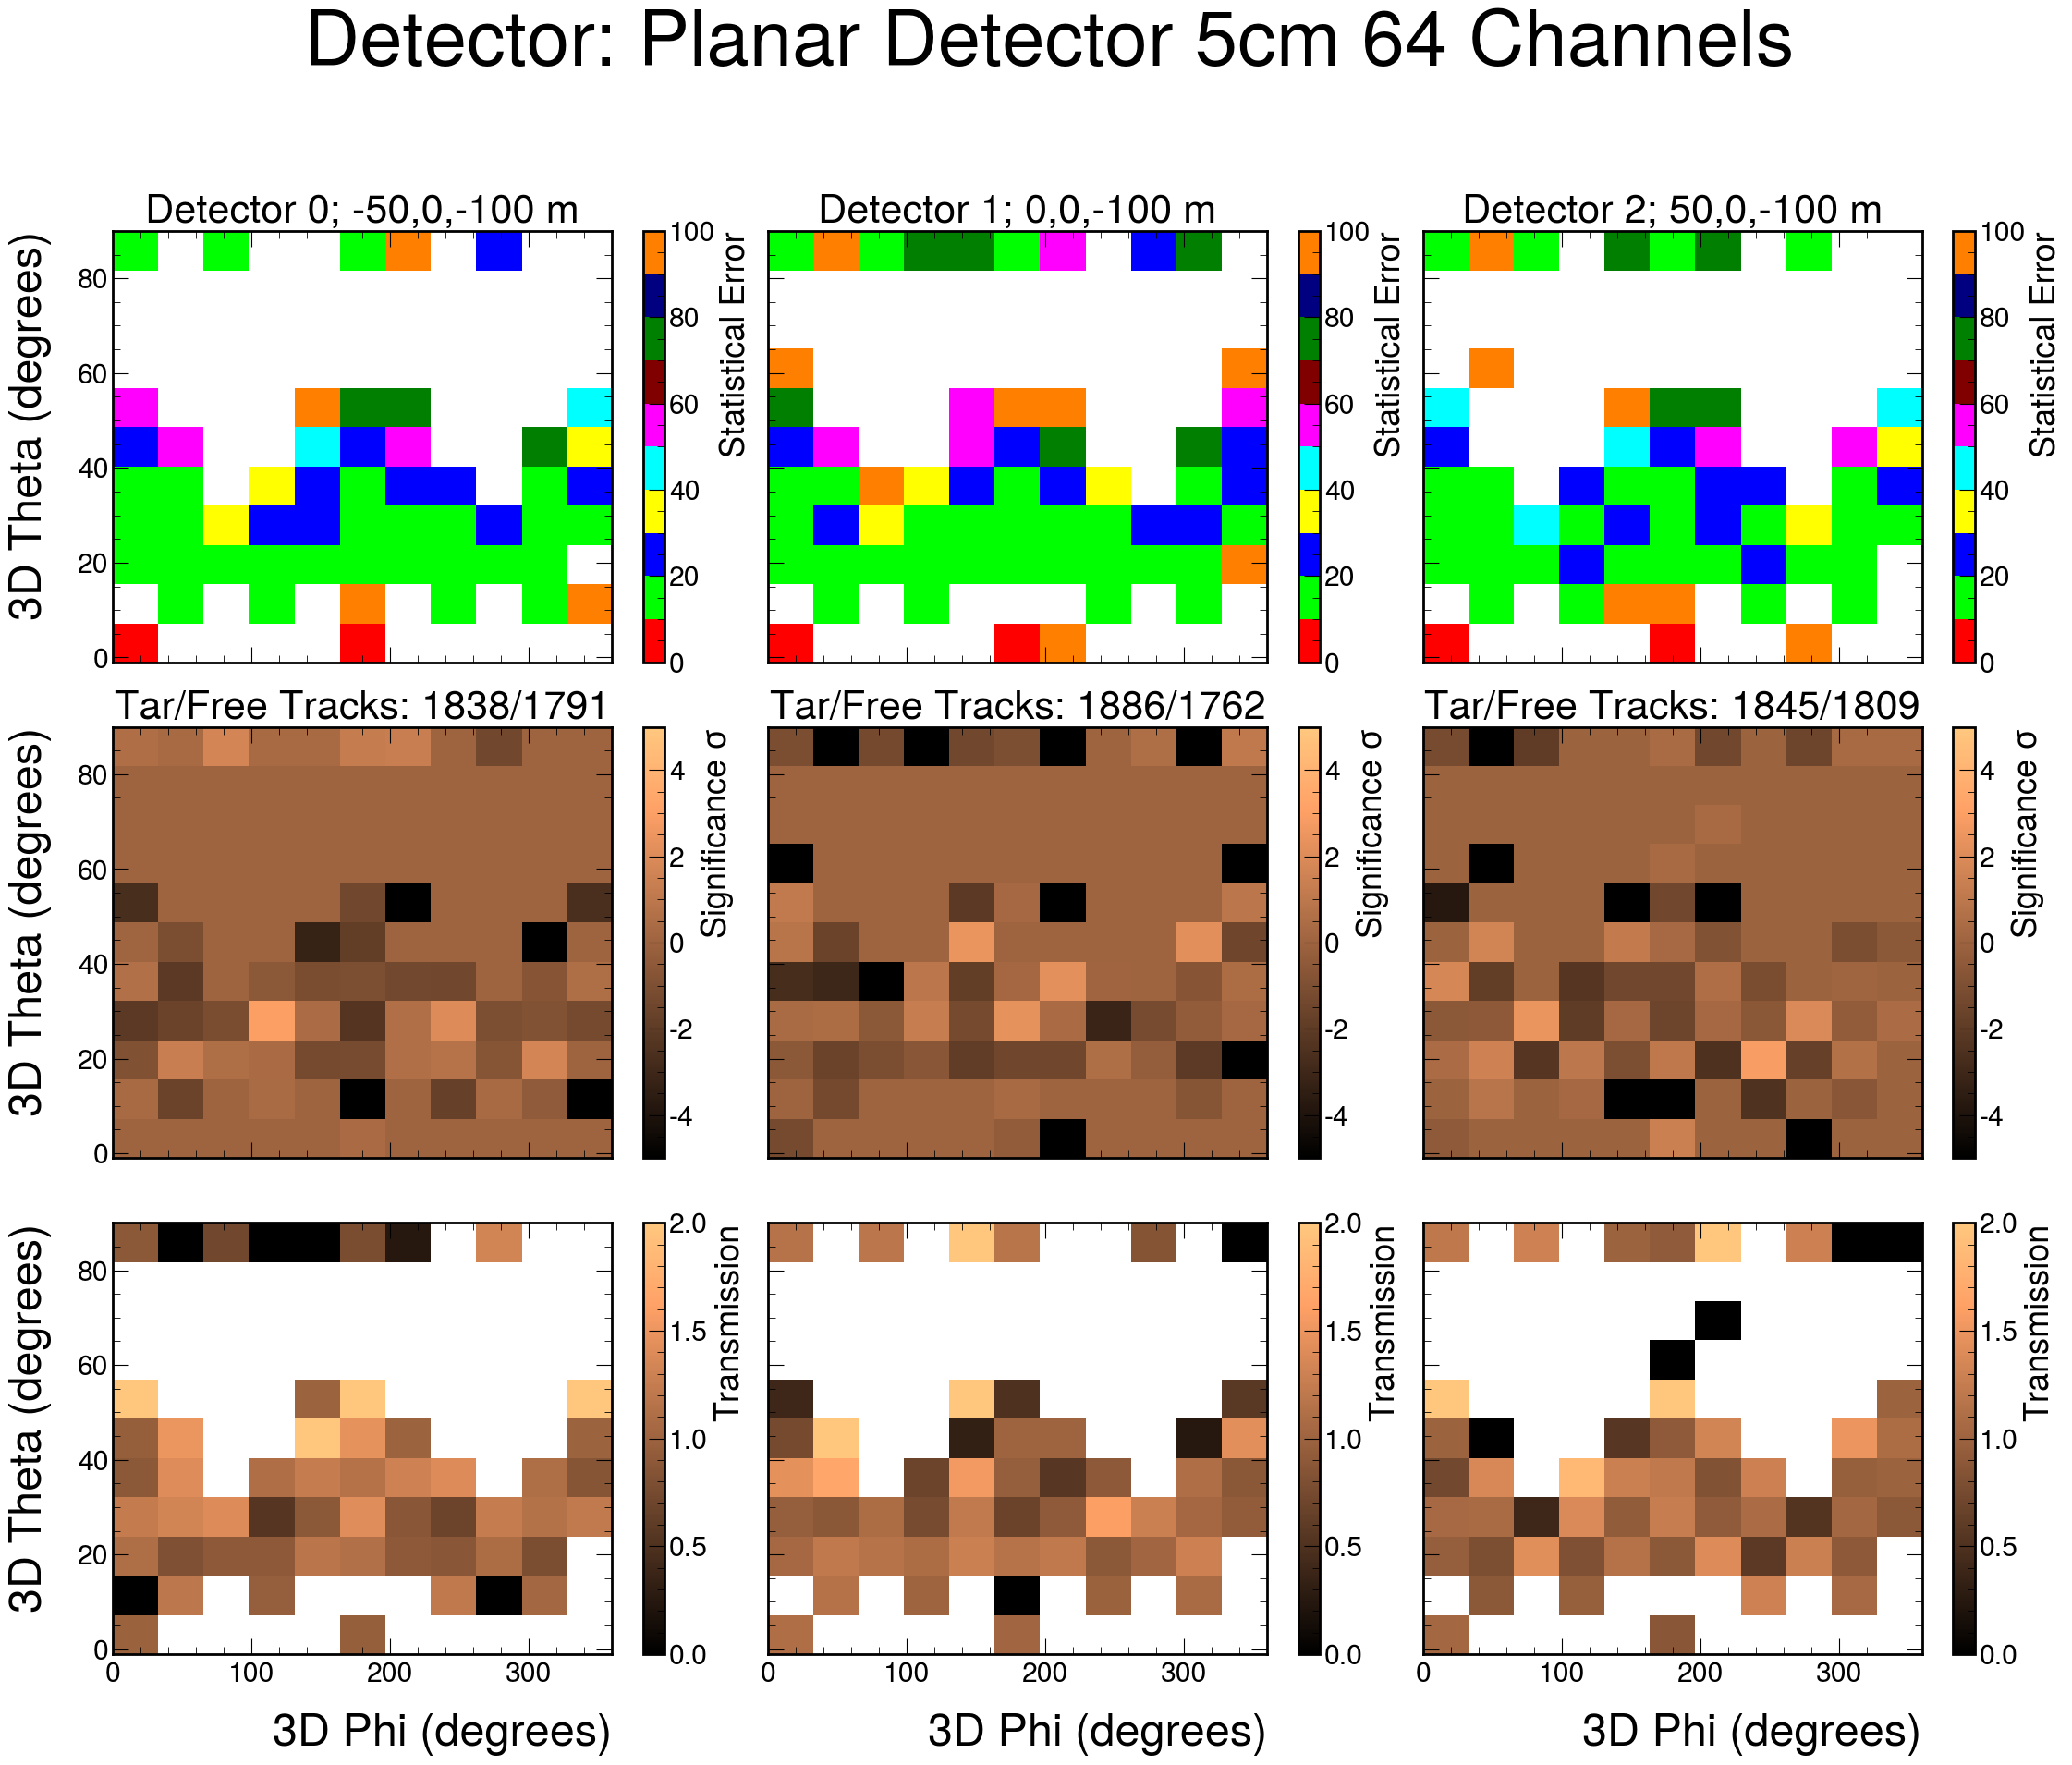

In [3]:
Zs = []
def project_point(r,x,y,z,x1,y1,z1):
    vx = x-x1
    vy = y-y1
    vz = z-z1
    theta = np.degrees(np.arccos(vz/np.sqrt(vx**2+vy**2+vz**2)))
    phi = phi_reconstruct(vx,vy,vz)
    d = np.sqrt(vx**2+vy**2+vz**2)
    radius = np.arcsin(r/d)
    return radius, theta, phi
    
colors = [
    (1, 0, 0),    # Red
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 1, 0),    # Yellow
    (0, 1, 1),    # Cyan
    (1, 0, 1),    # Magenta
    (0.5, 0, 0),  # Maroon
    (0, 0.5, 0),  # Dark Green
    (0, 0, 0.5),  # Navy
    (1, 0.5, 0)   # Orange
]
import matplotlib.colors as mcolors

# 2. Create the discrete colormap
cmap = mcolors.ListedColormap(colors)

target_pos =[]
'''
[
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]'''
radius = []
num = 3

acceptance = 1.5
positions_x = [-50, 0, 50]
positions_y = [0, 0, 0]
positions_z = [-100, -100, -100]


fig, ax = plt.subplots(3,num,figsize=(9*num,20),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05,hspace=0.15)
plt.suptitle('Detector: Planar Detector 5cm 64 Channels',fontsize=60,y=1)
H_list = []
im_handles = [None, None, None]
theta_bin = np.linspace(-1, 90, 12) #np.logspace(0.69897,1.7708520116421442, 15)
phi_bin = np.linspace(0, 360, 12)
num_bins = 10
discrete_cmap = plt.cm.get_cmap('viridis', num_bins)

ratio_hists = []
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = np.column_stack((df['theta_reco'][df['detector']==i].to_numpy(),df['phi_reco'][df['detector']==i].to_numpy()))
    reco_sim_angle = np.column_stack((dg['theta_reco'][dg['detector']==i].to_numpy(),dg['phi_reco'][dg['detector']==i].to_numpy()))
    T, xedges, yedges = np.histogram2d(np.mod(reco_sim_angle[:,1], 360),reco_sim_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(0,90)))

    H, xedges, yedges = np.histogram2d(np.mod(reco_data_angle[:,1], 360),reco_data_angle[:,0],bins=[phi_bin,theta_bin], range=((0, 360),(0,90)))
    H_list.append(H)
    plt.sca(ax[0,i%num])
    error = 1/np.sqrt(H.T)*100

    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1

    plt.ylim(top=90)
    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    plt.colorbar(label='Statistical Error')
    
    plt.sca(ax[1, i%num])

    Z = poisson_to_Z(H, T)
    Z = np.clip(Z,-10,10)
    Zs.append(Z)
    
    im2 = plt.imshow(Z.T, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='copper', aspect='auto',vmin=-5,vmax=5)
    im_handles[1] = im2
    plt.ylim(top=90)

    plt.title(f'Tar/Free Tracks: {len(reco_data_angle)}/{len(reco_sim_angle)}')
    plt.colorbar(label=r'Significance $\sigma$')

    
    plt.sca(ax[2,i%num])

    sim_H, sim_xedges, sim_yedges = np.histogram2d(
        np.mod(reco_sim_angle[:,1], 360), reco_sim_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    
    # Data histogram (note: should use reco_data_angle for both axes, not mix with reco_sim_angle[:,0]?)
    data_H, _, _ = np.histogram2d(
        np.mod(reco_data_angle[:,1], 360), reco_data_angle[:,0], bins=[phi_bin,theta_bin], range=((0, 360),(10,90))
    )
    
    ratio = np.divide(data_H, sim_H)
    ratio_hist = bh.Histogram(
        bh.axis.Variable(phi_bin),
        bh.axis.Variable(theta_bin),
    )    
    ratio_hist.view()[:] = ratio
    ratio_hists.append(ratio_hist)
    # Plot the ratio
    im3 = plt.imshow(
        ratio.T,                      # transpose so x=first axis, y=second
        origin="lower", 
        extent=[sim_xedges[0], sim_xedges[-1], sim_yedges[0], sim_yedges[-1]],
        aspect="auto",
        cmap='copper',
        vmin=0, vmax=2
    )
    im_handles[2] = im3
    plt.ylim(top=90)
    
    plt.colorbar(label='Transmission')
    plt.xlabel('3D Phi (degrees)', fontsize=35, labelpad=20)

ax[0, 0].set_ylabel('3D Theta (degrees)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel('3D Theta (degrees)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel('3D Theta (degrees)', fontsize=35, labelpad=20)

#ax[-1, -1].set_xlabel('Phi (degrees)', fontsize=35, labelpad=20)
H_min = min(h.min() for h in H_list)
H_max = max(h.max() for h in H_list)
#for row, im in enumerate(im_handles):
#    fig.colorbar(im, ax=ax[row,:], orientation='vertical', label=['Statistical Error','Significance Z','Transmission'][row], pad=0.01)
    
plt.show()

with open(path+"3D_hists.pkl", "wb") as f:
    pickle.dump(ratio_hists, f)

/tmp/ipykernel_1895930/414693208.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', num_bins)
/tmp/ipykernel_1895930/414693208.py:73: RuntimeWarning: divide by zero encountered in divide
  error = 1/np.sqrt(H.T)*100
/tmp/ipykernel_1895930/414693208.py:143: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(data_H, sim_H)
/tmp/ipykernel_1895930/414693208.py:143: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(data_H, sim_H)


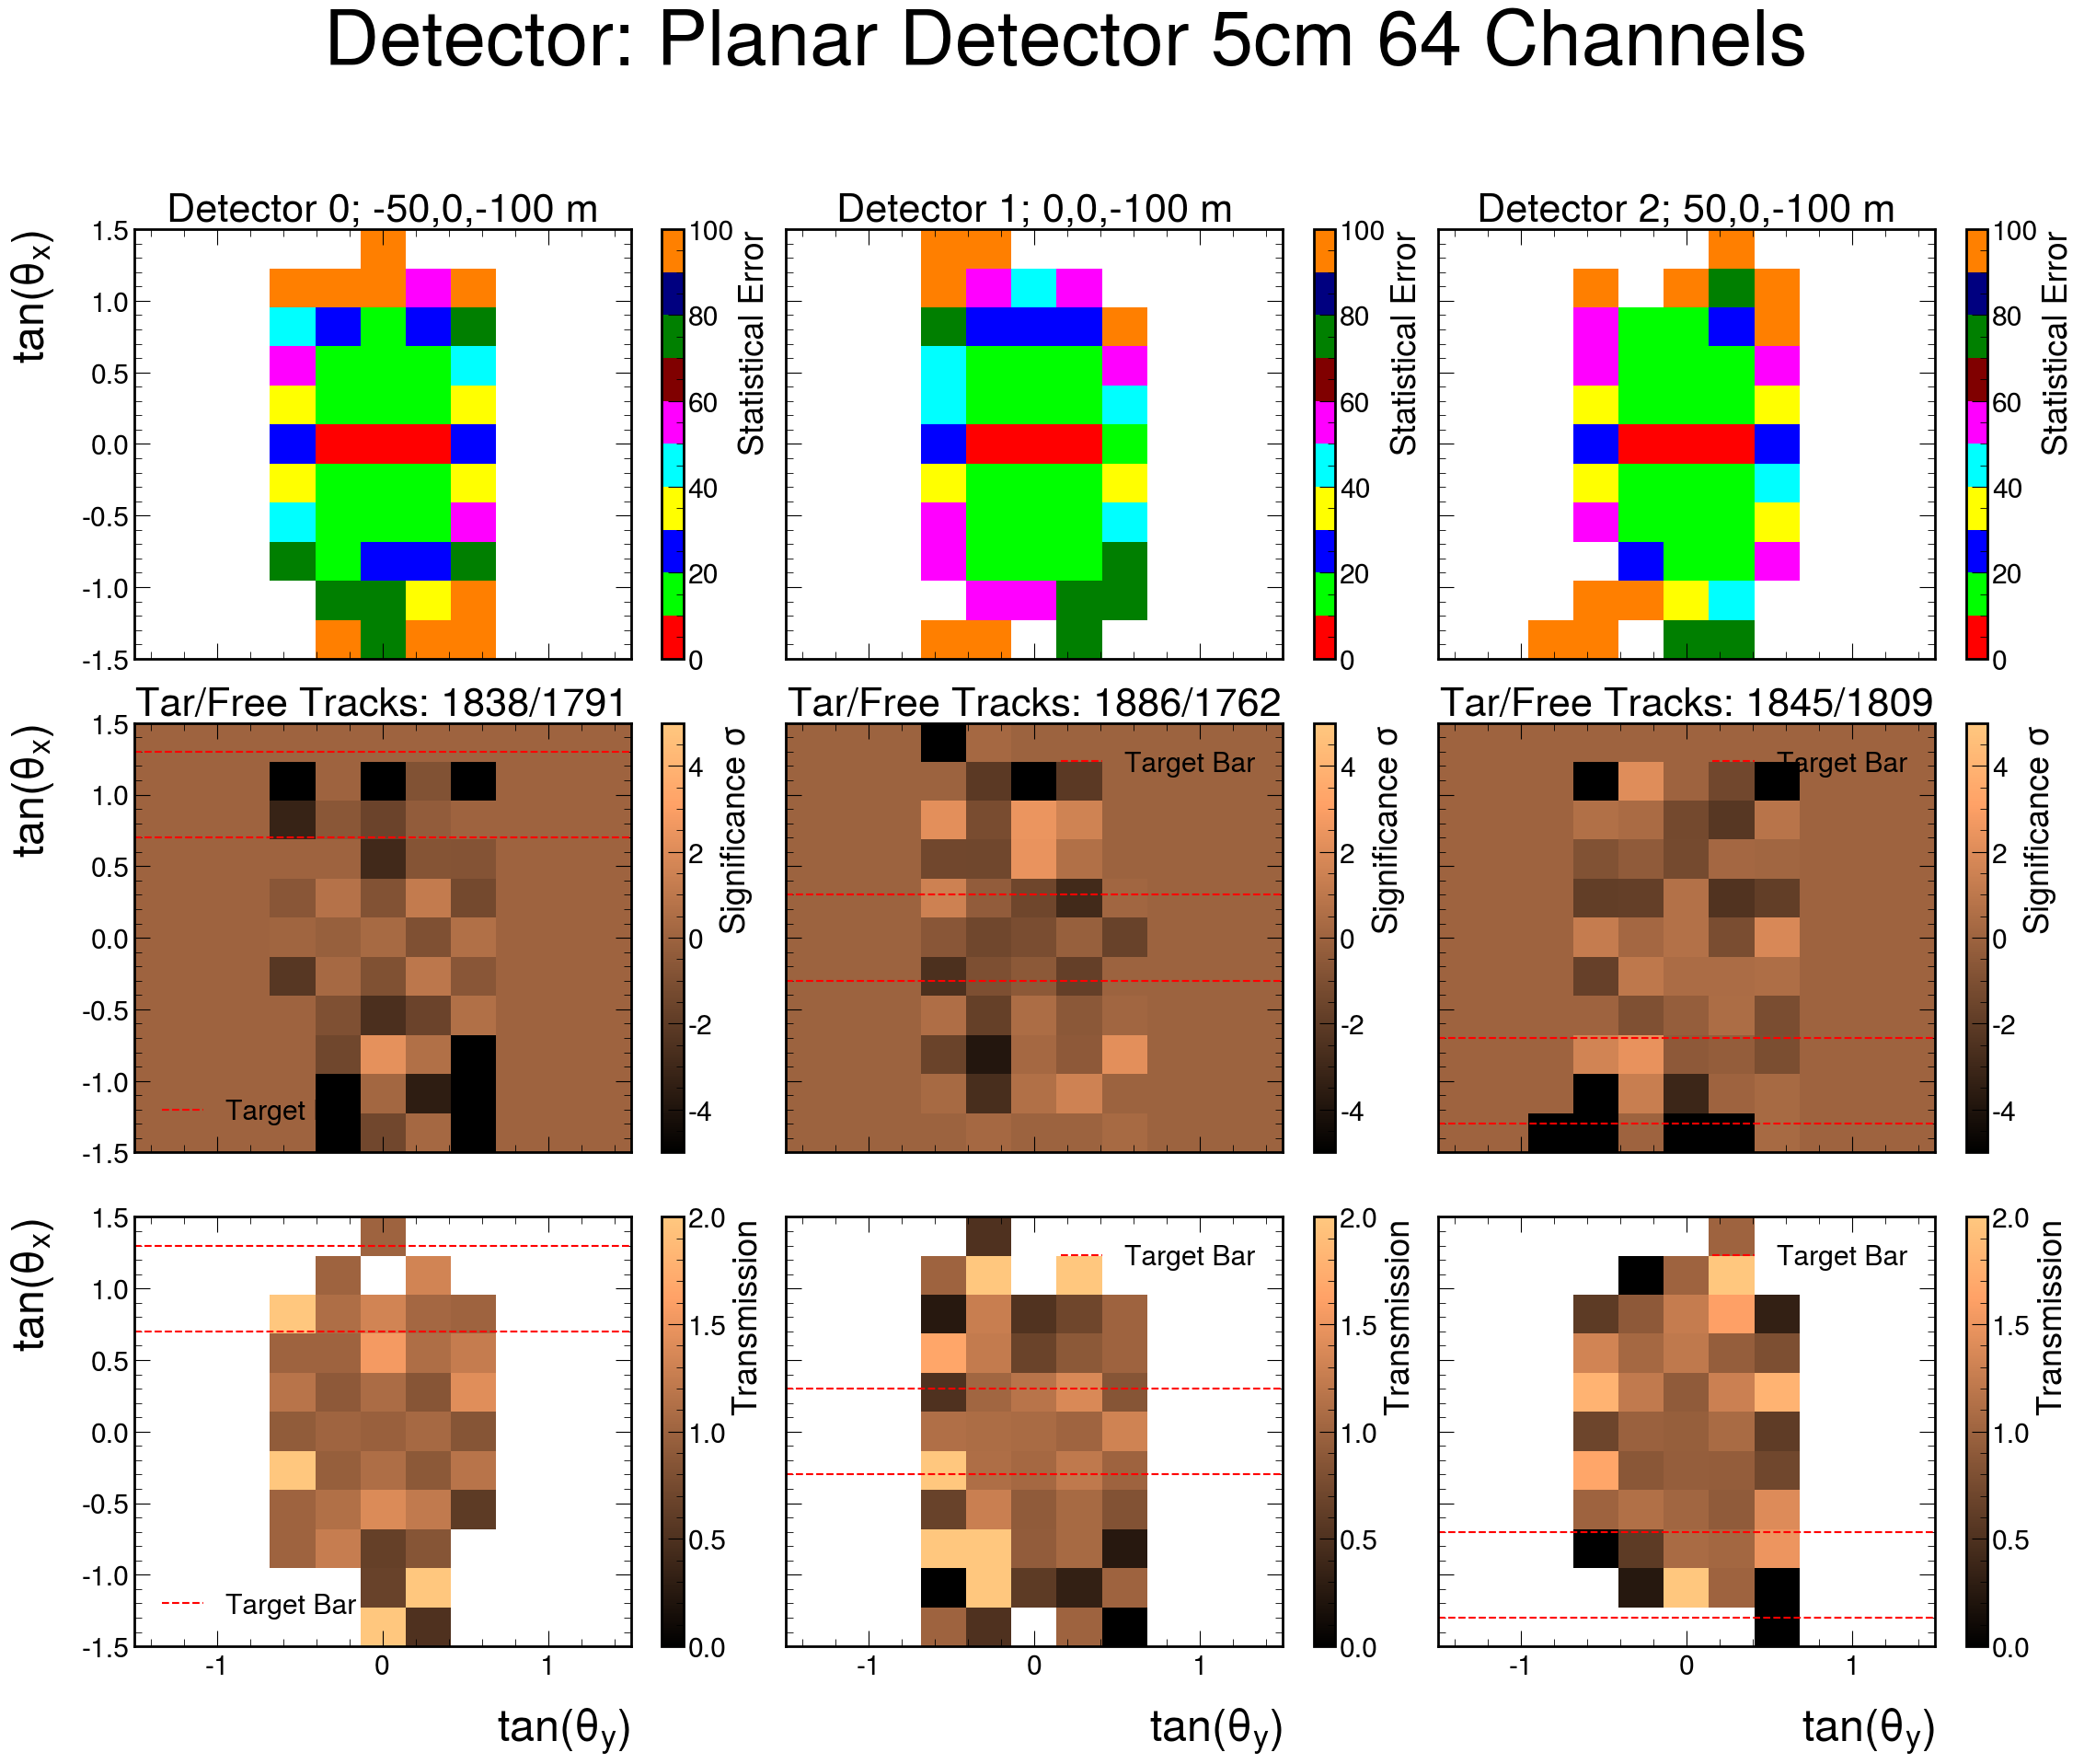

In [6]:
Zs = []
def project_point(r,x,y,z,x1,y1,z1):
    vx = x-x1
    vy = y-y1
    vz = z-z1
    theta = np.degrees(np.arccos(vz/np.sqrt(vx**2+vy**2+vz**2)))
    phi = phi_reconstruct(vx,vy,vz)
    d = np.sqrt(vx**2+vy**2+vz**2)
    radius = np.arcsin(r/d)
    return radius, theta, phi
    
colors = [
    (1, 0, 0),    # Red
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 1, 0),    # Yellow
    (0, 1, 1),    # Cyan
    (1, 0, 1),    # Magenta
    (0.5, 0, 0),  # Maroon
    (0, 0.5, 0),  # Dark Green
    (0, 0, 0.5),  # Navy
    (1, 0.5, 0)   # Orange
]
import matplotlib.colors as mcolors

# 2. Create the discrete colormap
cmap = mcolors.ListedColormap(colors)

target_pos =[]
'''
[
    [50, 0, -20],
    [0, 20, -5],
    [5, 0, -5],
    [-10, 0, -35],
    [0,40,-65],
    [0,-60,-20]
]'''
radius = []#[20, 5, 5, 5, 10, 10]
num = 3

acceptance = 1.5
positions_x = [-50, 0, 50]
positions_y = [0, 0, 0]
positions_z = [-100, -100, -100]

fig, ax = plt.subplots(3,num,figsize=(9*num,20),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.05,hspace=0.15)
plt.suptitle('Detector: Planar Detector 5cm 64 Channels',fontsize=60,y=1)
H_list = []
im_handles = [None, None, None]
theta_bin = np.linspace(-1.5, 1.5, 12) 
phi_bin = np.linspace(-1.5, 1.5, 12)
num_bins = 10
discrete_cmap = plt.cm.get_cmap('viridis', num_bins)

area=15


ratio_hist = []
for i in range(num):
    det_pos = (positions_x[i], positions_y[i], positions_z[i])
    reco_data_angle = np.column_stack((df['theta_reco_x'][df['detector']==i].to_numpy(),df['theta_reco_y'][df['detector']==i].to_numpy()))
    reco_sim_angle = np.column_stack((dg['theta_reco_x'][dg['detector']==i].to_numpy(),dg['theta_reco_y'][dg['detector']==i].to_numpy()))
    T, xedges, yedges = np.histogram2d(reco_sim_angle[:,1],reco_sim_angle[:,0],bins=[phi_bin,theta_bin])

    H, xedges, yedges = np.histogram2d(reco_data_angle[:,1],reco_data_angle[:,0],bins=[phi_bin,theta_bin])
    H_list.append(H)
    plt.sca(ax[0,i%num])
    error = 1/np.sqrt(H.T)*100

    im1 = plt.imshow(error, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=cmap, aspect='auto', vmin=0, vmax=100)
    im_handles[0] = im1

    plt.title(f'Detector {i}; {positions_x[i]},{positions_y[i]},{positions_z[i]} m')
    #plt.legend()
    plt.colorbar(label='Statistical Error')
    
    # Plot the Z-map
    plt.sca(ax[1, i%num])
    plt.axhline(theta_x(positions_x[i]+area,0,-50),linestyle='dashed',label='Target Bar',c='r')
    plt.axhline(theta_x(positions_x[i]-area,0,-50),linestyle='dashed',c='r')
    plt.legend()
    Z = poisson_to_Z(H, T)
    Z = np.clip(Z,-10,10)
    Zs.append(Z)
    im2 = plt.imshow(Z.T, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='copper', aspect='auto',vmin=-5,vmax=5)
    im_handles[1] = im2
    plt.title(f'Tar/Free Tracks: {len(reco_data_angle)}/{len(reco_sim_angle)}')
    
    plt.colorbar(label=r'Significance $\sigma$')

    
    
    plt.sca(ax[2,i%num])
    plt.axhline(theta_x(positions_x[i]+area,0,-50),linestyle='dashed',label='Target Bar',c='r')
    plt.axhline(theta_x(positions_x[i]-area,0,-50),linestyle='dashed',c='r')

    sim_H, sim_xedges, sim_yedges = np.histogram2d(
        reco_sim_angle[:,1], reco_sim_angle[:,0], bins=[phi_bin,theta_bin]
    )
    

    data_H, _, _ = np.histogram2d(
        reco_data_angle[:,1], reco_data_angle[:,0], bins=[phi_bin,theta_bin]
    )
    ratio = np.divide(data_H, sim_H)
    ratio_hist = bh.Histogram(
        bh.axis.Variable(phi_bin),
        bh.axis.Variable(theta_bin),
    )    
    ratio_hist.view()[:] = ratio
    ratio_hists.append(ratio_hist)
    # Plot the ratio
    im3 = plt.imshow(
        ratio.T,                      # transpose so x=first axis, y=second
        origin="lower", 
        extent=[sim_xedges[0], sim_xedges[-1], sim_yedges[0], sim_yedges[-1]],
        aspect="auto",
        cmap='copper',
        vmin=0, vmax=2
    )
    im_handles[2] = im3
    
    plt.colorbar(label='Transmission')
    plt.xlabel(r'tan($\theta_y$)', fontsize=35, labelpad=20)
    plt.legend()

ax[0, 0].set_ylabel(r'tan($\theta_x$)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel(r'tan($\theta_x$)', fontsize=35, labelpad=20)
ax[2, 0].set_ylabel(r'tan($\theta_x$)', fontsize=35, labelpad=20)

#ax[-1, -1].set_xlabel('Phi (degrees)', fontsize=35, labelpad=20)
H_min = min(h.min() for h in H_list)
H_max = max(h.max() for h in H_list)
#for row, im in enumerate(im_handles):
#    fig.colorbar(im, ax=ax[row,:], orientation='vertical', label=['Statistical Error','Significance Z','Transmission'][row], pad=0.01)
    
plt.show()

with open(path+"3D_tan_hists.pkl", "wb") as f:
    pickle.dump(ratio_hists, f)

Text(1, 0, 'Theta (degrees)')

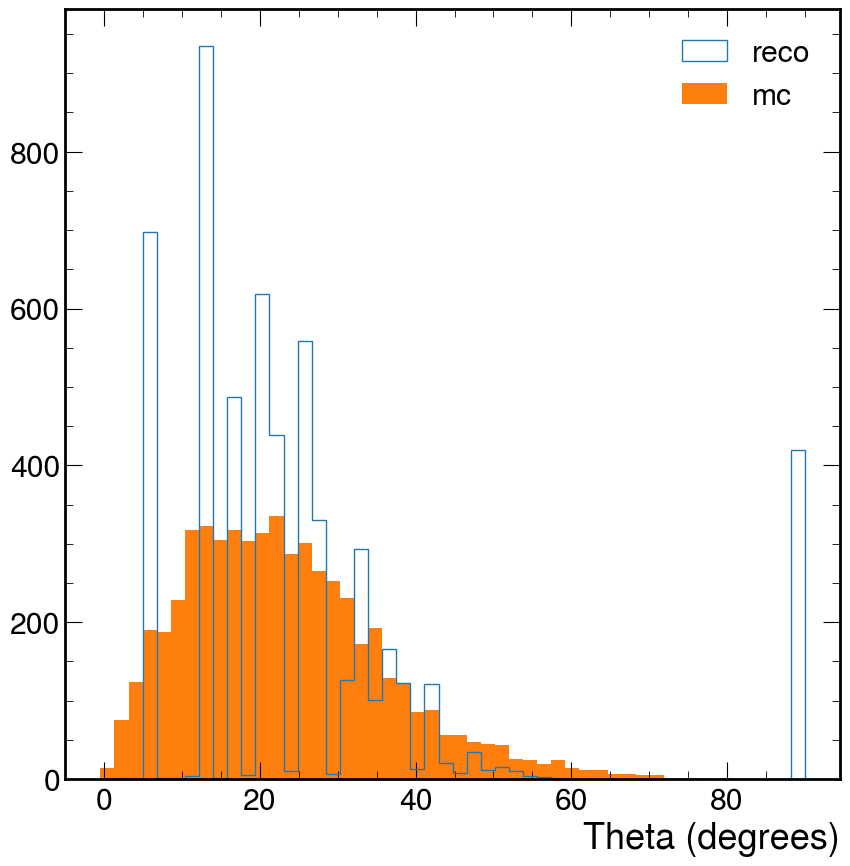

In [5]:
plt.hist(df['theta_reco'],label='reco',bins=50,range=(-0.5,90),histtype='step')
plt.hist(df['theta_true'],label='mc',bins=50,range=(-0.5,90))
plt.legend()
plt.xlabel('Theta (degrees)')